In [23]:
import pandas as pd
import numpy as np

# Rutas de tus archivos
path_sep = "../data/processed/sep_datos_tidy.csv"
path_inegi = "../data/processed/inegi_contexto_municipal.csv"
path_catalogo = "../data/processed/catalogo_escuelas_sonora_limpio.csv"

# Carga
sep = pd.read_csv(path_sep)
inegi = pd.read_csv(path_inegi)
catalogo = pd.read_csv(path_catalogo)

print(sep.shape, inegi.shape, catalogo.shape)


(1149305, 157) (445, 9) (13624, 8)


In [24]:
# Limpieza de nombres
sep['municipio'] = sep['n_municipi'].astype(str).str.upper().str.strip()
inegi['municipio'] = inegi['municipio'].astype(str).str.upper().str.strip()

# Convertir periodo_escolar (SEP) a año base
sep['anio'] = sep['periodo_escolar'].str.split('-').str[0].astype(int)

# Renombrar para coherencia
inegi.rename(columns={'periodo': 'anio'}, inplace=True)

print(sep[['municipio', 'anio']].head())
print(inegi[['municipio', 'anio']].head())


                   municipio  anio
0                   CALVILLO  2019
1             AGUASCALIENTES  2019
2        PABELLÓN DE ARTEAGA  2019
3             AGUASCALIENTES  2019
4  SAN FRANCISCO DE LOS ROMO  2019
  municipio  anio
0   ACONCHI  1995
1   ACONCHI  2000
2   ACONCHI  2005
3   ACONCHI  2010
4   ACONCHI  2015


In [25]:
sep_inegi = pd.merge(
    sep,
    inegi,
    on=['municipio', 'anio'],
    how='left',
    indicator=True
)

print(sep_inegi['_merge'].value_counts())
sep_inegi.head(3)


_merge
left_only     1144763
both             4542
right_only          0
Name: count, dtype: int64


,entidad,n_entidad,municipio,n_municipi,localidad,n_localidad,domicilio,clavecct,n_cct,turno,...,periodo_escolar,anio,grado_promedio_escolaridad,poblacion_asiste_escuela,poblacion_total,porcentaje_alfabetas,total_viviendas_habitadas,viviendas_con_automovil,viviendas_con_internet,_merge
0,1,AGUASCALIENTES,CALVILLO,CALVILLO,33,JALTICHE DE ARRIBA,CALLE RINCON DE ROMOS,01DPR0270P,SOR JUANA INES DE LA CRUZ,1,...,2019-2020,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,1,AGUASCALIENTES,AGUASCALIENTES,AGUASCALIENTES,1097,HACIENDA SAN MARCOS [FRACCIONAMIENTO],AVENIDA DE LAS PRESAS,01DPR0733G,RAFAEL FRANCISCO AGUILAR LOMELÍ,1,...,2019-2020,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,1,AGUASCALIENTES,PABELLÓN DE ARTEAGA,PABELLÓN DE ARTEAGA,10,EL GARABATO,CALLE VENUSTIANO CARRANZA,01DPR0175L,SALVADOR LUEVANO,1,...,2019-2020,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [26]:
# Contar escuelas y tipo de sostenimiento
sep_grouped = (
    sep.groupby(['municipio', 'anio', 'tipo_org_alumnos'])
      .size()
      .reset_index(name='total_escuelas')
)

sep_grouped.head()


,municipio,anio,tipo_org_alumnos,total_escuelas
0,ABALÁ,2019,COMPLETA,4
1,ABALÁ,2019,INCOMPLETA,7
2,ABALÁ,2019,NO APLICA EN ESTE NIVEL,5
3,ABALÁ,2020,COMPLETA,4
4,ABALÁ,2020,INCOMPLETA,8


In [27]:
cruce_final = pd.merge(
    sep_grouped,
    inegi,
    on=['municipio', 'anio'],
    how='left'
)

cruce_final.head()


,municipio,anio,tipo_org_alumnos,total_escuelas,grado_promedio_escolaridad,poblacion_asiste_escuela,poblacion_total,porcentaje_alfabetas,total_viviendas_habitadas,viviendas_con_automovil,viviendas_con_internet
0,ABALÁ,2019,COMPLETA,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABALÁ,2019,INCOMPLETA,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABALÁ,2019,NO APLICA EN ESTE NIVEL,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABALÁ,2020,COMPLETA,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABALÁ,2020,INCOMPLETA,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
pivot = cruce_final.pivot_table(
    index='municipio',
    columns='tipo_org_alumnos',
    values='total_escuelas',
    aggfunc='sum',
    fill_value=0
).reset_index()

# Añadir indicadores de contexto promedio
contexto_mean = inegi.groupby('municipio')[
    ['porcentaje_alfabetas', 'viviendas_con_internet', 'grado_promedio_escolaridad']
].mean().reset_index()

comparativa = pivot.merge(contexto_mean, on='municipio', how='left')
comparativa.head()


,municipio,COMPLETA,INCOMPLETA,NO APLICA EN ESTE NIVEL,porcentaje_alfabetas,viviendas_con_internet,grado_promedio_escolaridad
0,ABALÁ,20,44,27,NaN,NaN,NaN
1,ABASOLO,279,777,226,NaN,NaN,NaN
2,ABEJONES,8,2,9,NaN,NaN,NaN
3,ACACOYAGUA,56,293,67,NaN,NaN,NaN
4,ACAJETE,249,203,107,NaN,NaN,NaN


In [31]:
comparativa['dif_publico_privado'] = (
    comparativa.get('COMPLETA', 0) - comparativa.get('NO APLICA EN ESTE NIVEL', 0)
)

comparativa.sort_values('dif_publico_privado', ascending=False).head(30)


,municipio,COMPLETA,INCOMPLETA,NO APLICA EN ESTE NIVEL,porcentaje_alfabetas,viviendas_con_internet,grado_promedio_escolaridad,dif_publico_privado
1143,PUEBLA,5533,1243,1899,NaN,NaN,NaN,3634
806,JUÁREZ,4592,2492,1403,NaN,NaN,NaN,3189
597,GUADALAJARA,4461,1815,1432,NaN,NaN,NaN,3029
743,IZTAPALAPA,4257,1277,1274,NaN,NaN,NaN,2983
512,ECATEPEC DE MORELOS,4240,1263,1349,NaN,NaN,NaN,2891
2295,ZAPOPAN,3834,1836,1387,NaN,NaN,NaN,2447
979,MONTERREY,3683,1074,1435,NaN,NaN,NaN,2248
612,GUSTAVO A. MADERO,3392,612,1168,NaN,NaN,NaN,2224
856,LEÓN,3969,2273,1749,NaN,NaN,NaN,2220
2034,TIJUANA,3800,2539,1605,NaN,NaN,NaN,2195


In [32]:
# Porcentaje de nulos por columna
nulos = comparativa.isna().mean().sort_values(ascending=False)
print(nulos)

# Cuántos municipios tienen todos los indicadores nulos
sin_datos = comparativa[
    comparativa[['porcentaje_alfabetas','viviendas_con_internet','grado_promedio_escolaridad']].isna().all(axis=1)
]
print("Municipios sin datos de INEGI:", len(sin_datos))


viviendas_con_internet        0.977341
grado_promedio_escolaridad    0.977341
porcentaje_alfabetas          0.977341
municipio                     0.000000
NO APLICA EN ESTE NIVEL       0.000000
INCOMPLETA                    0.000000
COMPLETA                      0.000000
dif_publico_privado           0.000000
dtype: float64
Municipios sin datos de INEGI: 2286


In [33]:
# Filtrar Sonora si hay más estados mezclados
comparativa = comparativa[comparativa['municipio'].isin([
    'HERMOSILLO','CAJEME','NAVOJOA','NOGALES','GUAYMAS','SAN LUIS RIO COLORADO',
    'MAGDALENA','CABORCA','MOCTEZUMA','ALAMOS','SANTA ANA','CANANEA','HUATABAMPO',
    'EMPALME','SAHUARIPA','BAVIACORA','BACERAC','BANÁMICHI','BÁCUM','AGUA PRIETA'
])]

# Mantener solo municipios con datos válidos de contexto
comparativa = comparativa.dropna(
    subset=['porcentaje_alfabetas','grado_promedio_escolaridad'],
    how='all'
)

print("Municipios útiles:", len(comparativa))


Municipios útiles: 16


In [34]:
# Mantener solo municipios con datos válidos de contexto
comparativa = comparativa.dropna(
    subset=['porcentaje_alfabetas','grado_promedio_escolaridad'],
    how='all'
)

print("Municipios útiles:", len(comparativa))

Municipios útiles: 16


In [35]:
# Promedio estatal (de los que sí tienen datos)
media_estado = comparativa[['porcentaje_alfabetas','viviendas_con_internet','grado_promedio_escolaridad']].mean()

# Relleno por municipio (si existe)
comparativa[['porcentaje_alfabetas','viviendas_con_internet','grado_promedio_escolaridad']] = (
    comparativa.groupby('municipio')[['porcentaje_alfabetas','viviendas_con_internet','grado_promedio_escolaridad']]
    .transform(lambda x: x.fillna(x.mean()))
    .fillna(media_estado)
)

comparativa.isna().sum()


municipio                     0
COMPLETA                      0
INCOMPLETA                    0
NO APLICA EN ESTE NIVEL       0
porcentaje_alfabetas          0
viviendas_con_internet        0
grado_promedio_escolaridad    0
dif_publico_privado           0
dtype: int64

In [36]:
# Revisar si aún quedan nulos
comparativa[['porcentaje_alfabetas','viviendas_con_internet','grado_promedio_escolaridad']].isna().sum()

# Mostrar muestra de Hermosillo y otros municipios
comparativa.sample(5)


,municipio,COMPLETA,INCOMPLETA,NO APLICA EN ESTE NIVEL,porcentaje_alfabetas,viviendas_con_internet,grado_promedio_escolaridad,dif_publico_privado
607,GUAYMAS,468,527,297,96.285636,51.303590,9.133699,171
225,CAJEME,1149,852,548,97.084078,48.455846,9.789307,601
188,BACERAC,5,23,15,95.245260,25.512292,7.175109,-10
542,EMPALME,169,184,89,96.393786,40.820999,8.731705,80
51,ALAMOS,22,269,105,88.420375,16.358342,6.885369,-83


In [37]:
comparativa.to_csv("../data/processed/sep_inegi_comparativa_limpia.csv", index=False)
print("✅ Datos limpios guardados.")


✅ Datos limpios guardados.


## Educativos

In [40]:
import pandas as pd

# Crear una copia filtrada de Sonora
mask_sonora = (sep['n_entidad'].str.upper() == 'SONORA') | (sep['entidad'] == 26)
sep_sonora = sep.loc[mask_sonora].copy()  # 👈 con .copy() eliminamos el warning

# Normalizar valores de nivel
sep_sonora['nivel'] = sep_sonora['nivel'].str.upper().str.strip()

print(sep_sonora['nivel'].value_counts())


nivel
PRIMARIA      8969
PREESCOLAR    7937
SECUNDARIA    3797
INICIAL        971
Name: count, dtype: int64


In [41]:
df_preescolar = sep_sonora.query("nivel == 'PREESCOLAR'").copy()
df_primaria = sep_sonora.query("nivel == 'PRIMARIA'").copy()
df_secundaria = sep_sonora.query("nivel == 'SECUNDARIA'").copy()
df_inicial = sep_sonora.query("nivel == 'INICIAL'").copy()

print(f"Preescolar: {len(df_preescolar)} | Primaria: {len(df_primaria)} | Secundaria: {len(df_secundaria)} | Inicial: {len(df_inicial)}")


Preescolar: 7937 | Primaria: 8969 | Secundaria: 3797 | Inicial: 971


In [44]:
import numpy as np

def _pick_first(df, cols, default=0):
    """Devuelve la primera columna existente de `cols`. Si ninguna existe, devuelve un Series de default."""
    for c in cols:
        if c in df.columns:
            return df[c]
    return pd.Series(default, index=df.index, dtype='float64')

def _sum_or_zero(df, cols):
    """Suma columnas si existen; si ninguna, devuelve 0."""
    exist = [c for c in cols if c in df.columns]
    if exist:
        return df[exist].sum(axis=1, numeric_only=True)
    return pd.Series(0, index=df.index, dtype='float64')


In [42]:
def resumen_nivel(df, nombre_nivel):
    # Normaliza municipio (índice principal)
    df = df.copy()
    df['municipio'] = df['n_municipi'].astype(str).str.upper().str.strip()
    
    # Totales de alumnos (preferimos insc_t; si no, ins_t)
    df['_total_alumnos'] = _pick_first(df, ['insc_t', 'ins_t'], default=0)

    # Totales de docentes: preferimos 'tot_doc' (docentes H+M), si no 'doc_tot' (algunas bases),
    # si faltan ambos, calculamos con docente_h + docente_m
    docentes_fallback = _sum_or_zero(df, ['docente_h', 'docente_m'])
    df['_total_docentes'] = _pick_first(df, ['tot_doc', 'doc_tot'], default=np.nan).fillna(docentes_fallback)

    # Aulas: preferimos total de aulas en uso; si no, aulas adecuadas total; si no, suma por grado
    df['_aulas'] = _pick_first(df, ['aula_u_t', 'aula_a_t'], default=np.nan)
    if df['_aulas'].isna().all():
        df['_aulas'] = _sum_or_zero(df, [
            'aula_u_1','aula_u_2','aula_u_3','aula_u_4','aula_u_5','aula_u_6','aula_u_mg'
        ])
    
    # Talleres / Laboratorios / Egresados (si faltan, 0)
    df['_talleres'] = _pick_first(df, ['taller'], default=0)
    df['_laboratorios'] = _pick_first(df, ['laborat'], default=0)
    df['_egresados'] = _pick_first(df, ['egre_tot'], default=0)

    # Docentes por sexo (para % mujeres)
    df['_doc_h'] = _pick_first(df, ['docente_h'], default=0)
    df['_doc_m'] = _pick_first(df, ['docente_m'], default=0)

    # Agregamos por municipio + periodo escolar
    res = (
        df.groupby(['municipio','periodo_escolar'], as_index=False)
          .agg(
              total_alumnos=('_total_alumnos','sum'),
              total_docentes=('_total_docentes','sum'),
              aulas=('_aulas','sum'),
              talleres=('_talleres','sum'),
              laboratorios=('_laboratorios','sum'),
              egresados=('_egresados','sum'),
              docentes_h=('_doc_h','sum'),
              docentes_m=('_doc_m','sum')
          )
          .assign(
              nivel=nombre_nivel
          )
    )

    # Métricas derivadas (evitar /0)
    res['alumnos_por_docente'] = np.where(res['total_docentes']>0,
                                          res['total_alumnos']/res['total_docentes'],
                                          np.nan)
    res['docentes_mujer_pct'] = np.where((res['docentes_h']+res['docentes_m'])>0,
                                         (res['docentes_m']/(res['docentes_h']+res['docentes_m']))*100,
                                         np.nan)
    res['aulas_por_docente'] = np.where(res['total_docentes']>0,
                                        res['aulas']/res['total_docentes'],
                                        np.nan)
    res['egresados_por_100_alumnos'] = np.where(res['total_alumnos']>0,
                                                (res['egresados']/res['total_alumnos'])*100,
                                                np.nan)
    return res


In [46]:
# DataFrames por nivel
df_preescolar = sep_sonora.query("nivel == 'PREESCOLAR'").copy()
df_primaria   = sep_sonora.query("nivel == 'PRIMARIA'").copy()
df_secundaria = sep_sonora.query("nivel == 'SECUNDARIA'").copy()
df_inicial    = sep_sonora.query("nivel == 'INICIAL'").copy()

# Resúmenes
preescolar = resumen_nivel(df_preescolar, 'PREESCOLAR')
primaria   = resumen_nivel(df_primaria,   'PRIMARIA')
secundaria = resumen_nivel(df_secundaria, 'SECUNDARIA')
inicial    = resumen_nivel(df_inicial,    'INICIAL')

# Consolidado
niveles = pd.concat([preescolar, primaria, secundaria, inicial], ignore_index=True)

# ✅ resumen rápido por nivel educativo
cols = [c for c in ['total_alumnos','total_docentes'] if c in niveles.columns]
resumen_niveles = niveles.groupby('nivel', as_index=False)[cols].sum()
print(resumen_niveles)

niveles.head()


        nivel  total_alumnos  total_docentes
0     INICIAL          51065            1423
1  PREESCOLAR         439504           20721
2    PRIMARIA        1492632           57349
3  SECUNDARIA         743680           29875


,municipio,periodo_escolar,total_alumnos,total_docentes,aulas,talleres,laboratorios,egresados,docentes_h,docentes_m,nivel,alumnos_por_docente,docentes_mujer_pct,aulas_por_docente,egresados_por_100_alumnos
0,ACONCHI,2019-2020,138,6,6,0,0,0,0,6,PREESCOLAR,23.000000,100.0,1.000000,0.0
1,ACONCHI,2020-2021,125,5,8,0,0,0,0,5,PREESCOLAR,25.000000,100.0,1.600000,0.0
2,ACONCHI,2021-2022,122,6,5,0,0,0,0,6,PREESCOLAR,20.333333,100.0,0.833333,0.0
3,ACONCHI,2022-2023,101,6,7,0,0,0,0,6,PREESCOLAR,16.833333,100.0,1.166667,0.0
4,ACONCHI,2023-2024,105,6,6,0,0,0,0,6,PREESCOLAR,17.500000,100.0,1.000000,0.0


In [47]:
inegi['municipio'] = inegi['municipio'].astype(str).str.upper().str.strip()

niveles_inegi = niveles.merge(
    inegi[['municipio','grado_promedio_escolaridad','porcentaje_alfabetas','poblacion_asiste_escuela']],
    on='municipio', how='left'
)

# Métricas adicionales útiles
niveles_inegi['docentes_por_1000_alumnos'] = np.where(
    niveles_inegi['alumnos_por_docente'].notna() & (niveles_inegi['alumnos_por_docente']>0),
    1000.0 / niveles_inegi['alumnos_por_docente'],
    np.nan
)

niveles_inegi.head()


,municipio,periodo_escolar,total_alumnos,total_docentes,aulas,talleres,laboratorios,egresados,docentes_h,docentes_m,nivel,alumnos_por_docente,docentes_mujer_pct,aulas_por_docente,egresados_por_100_alumnos,grado_promedio_escolaridad,porcentaje_alfabetas,poblacion_asiste_escuela,docentes_por_1000_alumnos
0,ACONCHI,2019-2020,138,6,6,0,0,0,0,6,PREESCOLAR,23.0,100.0,1.0,0.0,NaN,NaN,NaN,43.478261
1,ACONCHI,2019-2020,138,6,6,0,0,0,0,6,PREESCOLAR,23.0,100.0,1.0,0.0,6.900000,94.758785,556.0,43.478261
2,ACONCHI,2019-2020,138,6,6,0,0,0,0,6,PREESCOLAR,23.0,100.0,1.0,0.0,7.400000,NaN,580.0,43.478261
3,ACONCHI,2019-2020,138,6,6,0,0,0,0,6,PREESCOLAR,23.0,100.0,1.0,0.0,7.810000,95.570000,667.0,43.478261
4,ACONCHI,2019-2020,138,6,6,0,0,0,0,6,PREESCOLAR,23.0,100.0,1.0,0.0,8.242048,96.029777,NaN,43.478261


In [48]:
preescolar.to_csv("../data/processed/sep_preescolar_sonora.csv", index=False)
primaria.to_csv("../data/processed/sep_primaria_sonora.csv", index=False)
secundaria.to_csv("../data/processed/sep_secundaria_sonora.csv", index=False)
inicial.to_csv("../data/processed/sep_inicial_sonora.csv", index=False)
niveles_inegi.to_csv("../data/processed/sep_niveles_con_inegi.csv", index=False)

print("✅ CSV guardados en data/processed/: preescolar, primaria, secundaria, inicial y consolidado con INEGI.")


✅ CSV guardados en data/processed/: preescolar, primaria, secundaria, inicial y consolidado con INEGI.


Graficas


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [51]:

# Carpetas de salida (ajústalas si lo deseas)
FIG_DIR = "../reports/figures"
TAB_DIR = "../reports/tables"
REP_DIR = "../reports"

os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)
os.makedirs(REP_DIR, exist_ok=True)

# Cargar datasets procesados
niveles_inegi = pd.read_csv("../data/processed/sep_niveles_con_inegi.csv")
# También el crudo filtrado (o el CSV de Sonora completo si lo tienes guardado)
sep = pd.read_csv("../data/processed/sep_datos_tidy.csv")

# Normalizaciones
niveles_inegi['municipio'] = niveles_inegi['municipio'].astype(str).str.upper().str.strip()
sep['municipio'] = sep['n_municipi'].astype(str).str.upper().str.strip()
sep['nivel'] = sep['nivel'].astype(str).str.upper().str.strip()
sep['control'] = sep['control'].astype(str).str.upper().str.strip()  # PÚBLICO / PRIVADO


In [52]:
# Top por nivel (promedios por municipio-periodo, luego promedio por municipio)
presion = (
    niveles_inegi
    .dropna(subset=['alumnos_por_docente'])
    .groupby(['nivel','municipio'], as_index=False)['alumnos_por_docente']
    .mean()
)

# Guardar top 10 por nivel
top_por_nivel = []
for lv in ['PREESCOLAR','PRIMARIA','SECUNDARIA']:
    tmp = (presion[presion['nivel']==lv]
           .sort_values('alumnos_por_docente', ascending=False)
           .head(10))
    tmp.to_csv(os.path.join(TAB_DIR, f"top10_presion_{lv.lower()}.csv"), index=False)
    top_por_nivel.append(tmp)

top_por_nivel[0].head()


,nivel,municipio,alumnos_por_docente
82,PREESCOLAR,SANTA CRUZ,48.233333
73,PREESCOLAR,ROSARIO,44.293333
72,PREESCOLAR,RAYÓN,35.000000
55,PREESCOLAR,HUÉPAC,33.700000
54,PREESCOLAR,HUÁSABAS,32.000000


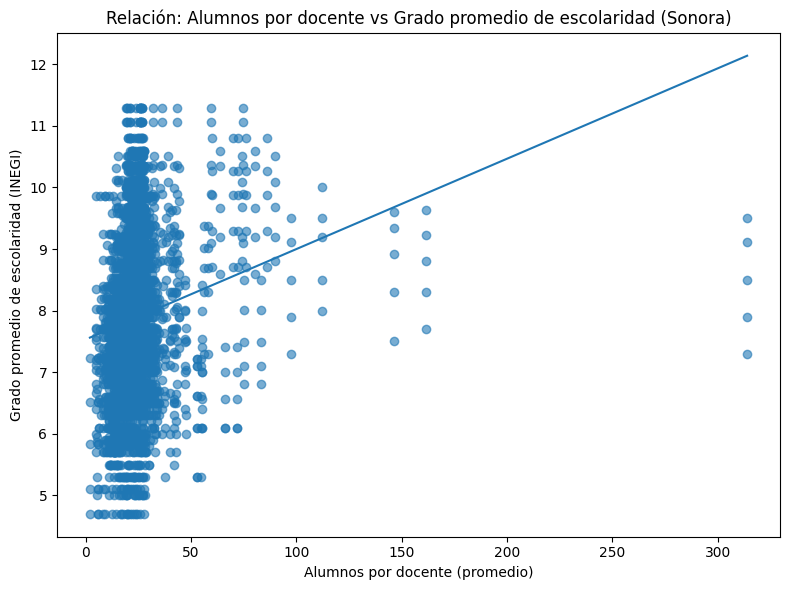

In [53]:
plt.figure(figsize=(8,6))
data_sc = niveles_inegi.dropna(subset=['alumnos_por_docente','grado_promedio_escolaridad'])

plt.scatter(
    data_sc['alumnos_por_docente'],
    data_sc['grado_promedio_escolaridad'],
    alpha=0.6
)
# Trend line
x = data_sc['alumnos_por_docente'].values
y = data_sc['grado_promedio_escolaridad'].values
if len(x) > 2:
    m,b = np.polyfit(x, y, 1)
    xs = np.linspace(x.min(), x.max(), 100)
    plt.plot(xs, m*xs+b)

plt.title('Relación: Alumnos por docente vs Grado promedio de escolaridad (Sonora)')
plt.xlabel('Alumnos por docente (promedio)')
plt.ylabel('Grado promedio de escolaridad (INEGI)')
plt.tight_layout()
scatter_path = os.path.join(FIG_DIR, "scatter_alum_doc_vs_grado.png")
plt.savefig(scatter_path, dpi=200)
plt.show()


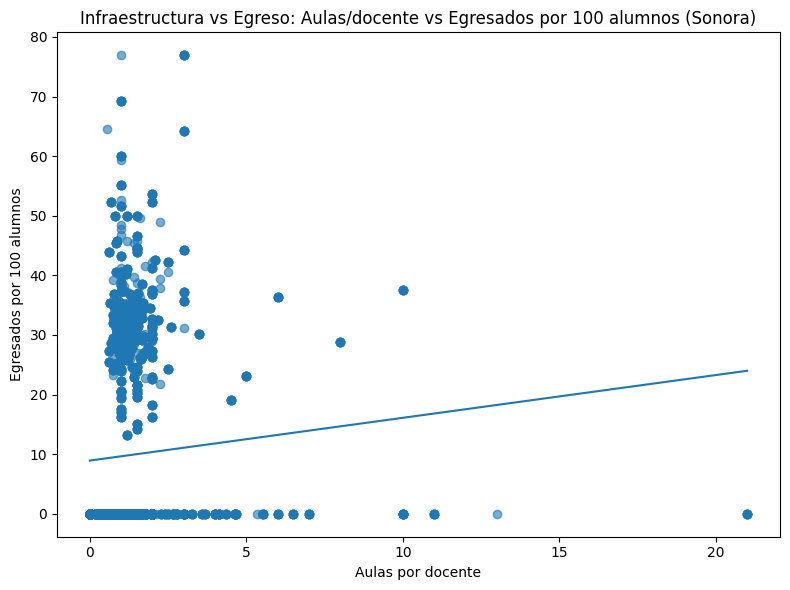

In [54]:
plt.figure(figsize=(8,6))
data_inf = niveles_inegi.dropna(subset=['aulas_por_docente','egresados_por_100_alumnos'])

plt.scatter(
    data_inf['aulas_por_docente'],
    data_inf['egresados_por_100_alumnos'],
    alpha=0.6
)
# Trend line
x = data_inf['aulas_por_docente'].values
y = data_inf['egresados_por_100_alumnos'].values
if len(x) > 2:
    m,b = np.polyfit(x, y, 1)
    xs = np.linspace(x.min(), x.max(), 100)
    plt.plot(xs, m*xs+b)

plt.title('Infraestructura vs Egreso: Aulas/docente vs Egresados por 100 alumnos (Sonora)')
plt.xlabel('Aulas por docente')
plt.ylabel('Egresados por 100 alumnos')
plt.tight_layout()
infra_path = os.path.join(FIG_DIR, "scatter_aulasdoc_vs_egreso.png")
plt.savefig(infra_path, dpi=200)
plt.show()


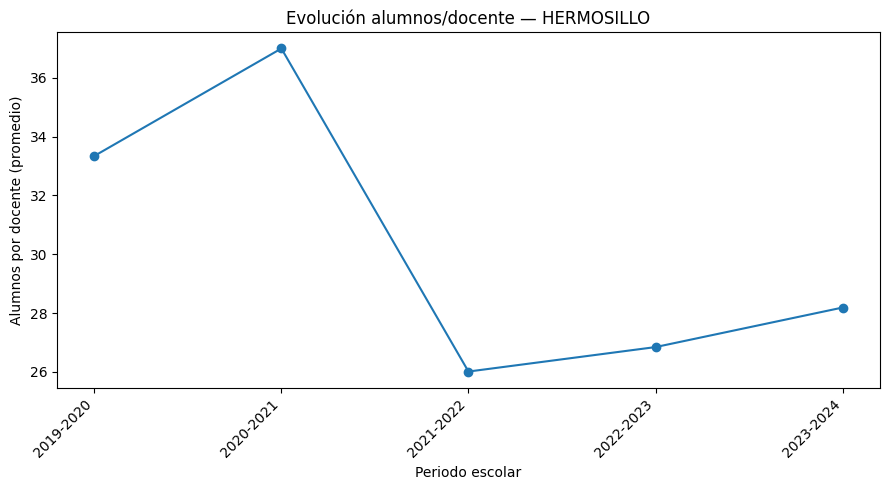

In [55]:
MUNICIPIO_FOCO = "HERMOSILLO"

serie = (
    niveles_inegi[niveles_inegi['municipio'] == MUNICIPIO_FOCO]
    .dropna(subset=['alumnos_por_docente'])
    .groupby(['periodo_escolar'], as_index=False)['alumnos_por_docente']
    .mean()
    .sort_values('periodo_escolar')
)

plt.figure(figsize=(9,5))
plt.plot(serie['periodo_escolar'], serie['alumnos_por_docente'], marker='o')
plt.xticks(rotation=45, ha='right')
plt.title(f'Evolución alumnos/docente — {MUNICIPIO_FOCO}')
plt.xlabel('Periodo escolar')
plt.ylabel('Alumnos por docente (promedio)')
plt.tight_layout()
evo_path = os.path.join(FIG_DIR, f"serie_alum_doc_{MUNICIPIO_FOCO.lower()}.png")
plt.savefig(evo_path, dpi=200)
plt.show()


In [56]:
sep_son = sep[(sep['n_entidad'].str.upper()=='SONORA') | (sep['entidad']==26)].copy()
sep_son['_alumnos'] = sep_son['insc_t'].fillna(sep_son.get('ins_t', 0))
sep_son['_alumnos'] = pd.to_numeric(sep_son['_alumnos'], errors='coerce').fillna(0)

part_nivel = (
    sep_son.groupby(['nivel','control'], as_index=False)['_alumnos'].sum()
)
part_nivel_piv = part_nivel.pivot_table(index='nivel', columns='control', values='_alumnos', fill_value=0).reset_index()
part_nivel_piv.to_csv(os.path.join(TAB_DIR, "participacion_publico_privado_por_nivel.csv"), index=False)
part_nivel_piv


control,nivel,PRIVADO,PÚBLICO
0,INICIAL,37145.0,13920.0
1,PREESCOLAR,81446.0,358058.0
2,PRIMARIA,189499.0,1303133.0
3,SECUNDARIA,90534.0,653146.0


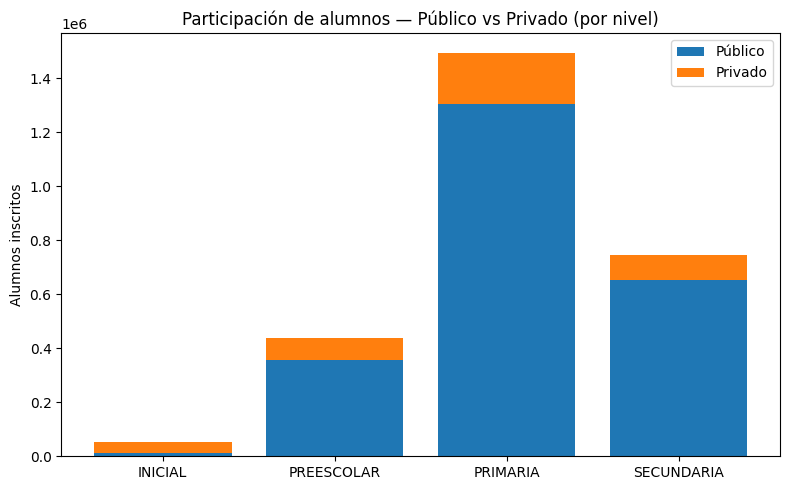

In [57]:
dfb = part_nivel_piv.copy()
pub = dfb.get('PÚBLICO', 0)
pri = dfb.get('PRIVADO', 0)

plt.figure(figsize=(8,5))
ind = np.arange(len(dfb['nivel']))
plt.bar(ind, pub, label='Público')
plt.bar(ind, pri, bottom=pub, label='Privado')
plt.xticks(ind, dfb['nivel'], rotation=0)
plt.ylabel('Alumnos inscritos')
plt.title('Participación de alumnos — Público vs Privado (por nivel)')
plt.legend()
plt.tight_layout()
stack_path = os.path.join(FIG_DIR, "barras_publico_privado_por_nivel.png")
plt.savefig(stack_path, dpi=200)
plt.show()


In [58]:
mun_priv = (
    sep_son.groupby(['municipio','nivel','control'], as_index=False)['_alumnos'].sum()
    .pivot_table(index=['municipio','nivel'], columns='control', values='_alumnos', fill_value=0)
    .reset_index()
)

mun_priv['ratio_pub_priv'] = mun_priv.get('PÚBLICO',0) / mun_priv.get('PRIVADO',1).replace(0,1)
mun_priv = mun_priv.sort_values('ratio_pub_priv', ascending=False)
mun_priv.to_csv(os.path.join(TAB_DIR, "ratio_publico_privado_municipio_nivel.csv"), index=False)
mun_priv.head(10)


control,municipio,nivel,PRIVADO,PÚBLICO,ratio_pub_priv
84,ETCHOJOA,PRIMARIA,0.0,30111.0,30111.0
85,ETCHOJOA,SECUNDARIA,0.0,15335.0,15335.0
52,BÁCUM,PRIMARIA,0.0,11865.0,11865.0
45,BENITO JUÁREZ,PRIMARIA,0.0,11384.0,11384.0
83,ETCHOJOA,PREESCOLAR,0.0,10938.0,10938.0
183,SAN IGNACIO RÍO MUERTO,PRIMARIA,0.0,7635.0,7635.0
194,SAN MIGUEL DE HORCASITAS,PRIMARIA,0.0,6234.0,6234.0
12,ALTAR,PRIMARIA,0.0,5838.0,5838.0
53,BÁCUM,SECUNDARIA,0.0,5652.0,5652.0
46,BENITO JUÁREZ,SECUNDARIA,0.0,5473.0,5473.0


In [59]:
corr_cols = [
    'alumnos_por_docente', 'aulas_por_docente', 'egresados_por_100_alumnos',
    'grado_promedio_escolaridad', 'porcentaje_alfabetas', 'poblacion_asiste_escuela'
]
corr_df = niveles_inegi[corr_cols].corr(method='pearson')
corr_df.to_csv(os.path.join(TAB_DIR, "correlaciones_clave.csv"))
corr_df


,alumnos_por_docente,aulas_por_docente,egresados_por_100_alumnos,grado_promedio_escolaridad,porcentaje_alfabetas,poblacion_asiste_escuela
alumnos_por_docente,1.000000,0.872838,-0.001789,0.179950,0.110651,0.145920
aulas_por_docente,0.872838,1.000000,0.055002,0.064153,0.070922,0.068033
egresados_por_100_alumnos,-0.001789,0.055002,1.000000,-0.041292,0.003375,-0.039904
grado_promedio_escolaridad,0.179950,0.064153,-0.041292,1.000000,0.708396,0.497341
porcentaje_alfabetas,0.110651,0.070922,0.003375,0.708396,1.000000,0.189168
poblacion_asiste_escuela,0.145920,0.068033,-0.039904,0.497341,0.189168,1.000000


In [60]:
# Mayor presión (alumnos/docente) global
top_presion = (
    niveles_inegi.dropna(subset=['alumnos_por_docente'])
    .groupby(['municipio','nivel'], as_index=False)['alumnos_por_docente']
    .mean()
    .sort_values('alumnos_por_docente', ascending=False)
    .head(10)
)
top_presion.to_csv(os.path.join(TAB_DIR, "top10_presion_global.csv"), index=False)

# Mayor egreso por 100 alumnos
top_egreso = (
    niveles_inegi.dropna(subset=['egresados_por_100_alumnos'])
    .groupby(['municipio','nivel'], as_index=False)['egresados_por_100_alumnos']
    .mean()
    .sort_values('egresados_por_100_alumnos', ascending=False)
    .head(10)
)
top_egreso.to_csv(os.path.join(TAB_DIR, "top10_egreso_por100.csv"), index=False)

# Menor grado promedio (contexto vulnerable)
low_grado = (
    niveles_inegi.dropna(subset=['grado_promedio_escolaridad'])
    .groupby('municipio', as_index=False)['grado_promedio_escolaridad'].mean()
    .sort_values('grado_promedio_escolaridad', ascending=True)
    .head(10)
)
low_grado.to_csv(os.path.join(TAB_DIR, "bottom10_grado_promedio.csv"), index=False)

top_presion.head(), top_egreso.head(), low_grado.head()


(       municipio    nivel  alumnos_por_docente
 121    MAGDALENA  INICIAL           112.000000
 54       CABORCA  INICIAL           101.495238
 3    AGUA PRIETA  INICIAL            81.666667
 58        CAJEME  INICIAL            72.940036
 78       EMPALME  INICIAL            72.305556,
            municipio       nivel  egresados_por_100_alumnos
 231  VILLA PESQUEIRA  SECUNDARIA                  48.049740
 242           ÓNAVAS  SECUNDARIA                  40.152555
 127          MAZATÁN  SECUNDARIA                  39.379821
 71           CUCURPE  SECUNDARIA                  37.948052
 222         TUBUTAMA  SECUNDARIA                  37.525216,
                    municipio  grado_promedio_escolaridad
 41  SAN MIGUEL DE HORCASITAS                    5.766883
 37                  QUIRIEGO                    5.877301
 7                   BACANORA                    6.414104
 38                   ROSARIO                    6.465731
 32                    ONAVAS                    6.603